### 학습목표
1. 소비 우수고객 찾기
2. 고객 retention 

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32
}
retail = pd.read_csv('data/OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 우수 고객 확인
 - 구매 횟수 기준
 - 지불 금액 기준

In [3]:
retail.groupby('CustomerID').count()['Quantity'].sort_values(ascending=False)

CustomerID
17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
         ... 
17846       1
13017       1
13099       1
13106       1
12346       1
Name: Quantity, Length: 4338, dtype: int64

In [4]:
retail.groupby('CustomerID').sum()['CheckoutPrice'].sort_values(ascending=False)

CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
           ...    
16878        13.30
17956        12.75
16454         6.90
14792         6.20
16738         3.75
Name: CheckoutPrice, Length: 4338, dtype: float64

#### 사용자 retention 분석
 - 월간 사용자 cohort를 바탕으로 월별 재구매율(retention) 분석하기
 - heatmap으로 한눈에 재구매율을 파악 가능
   -![코호트 분석](https://analyticsmarketing.co.kr/wp-content/uploads/2017/08/%EA%B5%AC%EA%B8%80%EC%95%A0%EB%84%90%EB%A6%AC%ED%8B%B1%EC%8A%A4_%EC%BD%94%ED%98%B8%ED%8A%B8_01.png) 출처: https://analyticsmarketing.co.kr/digital-analytics/google-analytics/1527/
   

#### 사용자 기준으로 최초 구매한 월(month) 연산하기
 - Month : 구매월(일(day)을 무시) 
 - MonthStarted: 사용자가 최초 구매한 달

In [5]:
def get_month_as_datetime(date):
    return datetime(date.year, date.month, 1)

retail['Month'] = retail['InvoiceDate'].apply(get_month_as_datetime)

retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice,Month
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01


In [6]:
month_group = retail.groupby('CustomerID')['Month']
retail['MonthStarted'] = month_group.transform(np.min)

retail.tail()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice,Month,MonthStarted
397879,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-01,2011-08-01
397880,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-01,2011-08-01
397881,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01
397882,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01
397883,541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,14.85,2011-12-01,2011-08-01


#### 기준이 되는 월과 실제 구매 월의 차이 계산하기
 - 각 구매가 최초 구매로 부터 얼마의 월이 지났는지 연산
 - MonthPassed : 최초 구매월로부터의 월 차이

In [7]:
retail['MonthPassed'] = (retail['Month'].dt.year - retail['MonthStarted'].dt.year) * 12 + \
    (retail['Month'].dt.month - retail['MonthStarted'].dt.month)

In [8]:
retail.tail()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice,Month,MonthStarted,MonthPassed
397879,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011-12-01,2011-08-01,4
397880,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011-12-01,2011-08-01,4
397881,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01,4
397882,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011-12-01,2011-08-01,4
397883,541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,14.85,2011-12-01,2011-08-01,4


#### 기준 월, MonthPassed를 기준으로 고객 카운팅
 - 기준이 되는 월과 그 월로부터 지난 기간의 고객 수를 계산

In [9]:
def get_unique_no(x):
    return len(np.unique(x))

cohort_group = retail.groupby(['MonthStarted', 'MonthPassed'])
cohort_df = cohort_group['CustomerID'].apply(get_unique_no).reset_index()
cohort_df.head()

,MonthStarted,MonthPassed,CustomerID
0,2010-12-01,0,885
1,2010-12-01,1,324
2,2010-12-01,2,286
3,2010-12-01,3,340
4,2010-12-01,4,321


#### 테이블 피벗
 - pivot 함수를 이용하여 index는 MonthStarted, columns을 MonthPassed로 변경하여 테이블 변경
 - 첫번째 column을 기준으로 100분위 연산

In [10]:
cohort_df = cohort_df.pivot(index='MonthStarted', columns='MonthPassed')
cohort_df.head()

CustomerID                                                   \
MonthPassed          0      1      2      3      4      5      6      7    
MonthStarted                                                               
2010-12-01        885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0   
2011-01-01        417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0   
2011-02-01        380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   
2011-03-01        452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0   
2011-04-01        300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   

                                                 
MonthPassed      8      9      10     11     12  
MonthStarted                                     
2010-12-01    313.0  350.0  331.0  445.0  235.0  
2011-01-01    125.0  136.0  152.0   49.0    NaN  
2011-02-01     94.0  116.0   26.0    NaN    NaN  
2011-03-01    126.0   39.0    NaN    NaN    NaN  
2011-04-01     22.0    NaN    NaN    NaN    NaN

In [11]:
customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100
customer_cohort = customer_cohort.round(decimals=2)

customer_cohort

CustomerID                                                   \
MonthPassed          0      1      2      3      4      5      6      7    
MonthStarted                                                               
2010-12-01        100.0  36.61  32.32  38.42  36.27  39.77  36.27  34.92   
2011-01-01        100.0  22.06  26.62  23.02  32.13  28.78  24.70  24.22   
2011-02-01        100.0  18.68  18.68  28.42  27.11  24.74  25.26  27.89   
2011-03-01        100.0  15.04  25.22  19.91  22.35  16.81  26.77  23.01   
2011-04-01        100.0  21.33  20.33  21.00  19.67  22.67  21.67  26.00   
2011-05-01        100.0  19.01  17.25  17.25  20.77  23.24  26.41   9.51   
2011-06-01        100.0  17.36  15.70  26.45  23.14  33.47   9.50    NaN   
2011-07-01        100.0  18.09  20.74  22.34  27.13  11.17    NaN    NaN   
2011-08-01        100.0  20.71  24.85  24.26  12.43    NaN    NaN    NaN   
2011-09-01        100.0  23.41  30.10  11.37    NaN    NaN    NaN    NaN   
2011-10-01        100.0  24.02  11.45    NaN    NaN    NaN    NaN    NaN   
2011-11-01        100.0  11.15    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01        100.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                                                 
MonthPassed      8      9      10     11     12  
MonthStarted                                     
2010-12-01    35.37  39.55  37.40  50.28  26.55  
2011-01-01    29.98  32.61  36.45  11.75    NaN  
2011-02-01    24.74  30.53   6.84    NaN    NaN  
2011-03-01    27.88   8.63    NaN    NaN    NaN  
2011-04-01     7.33    NaN    NaN    NaN    NaN  
2011-05-01      NaN    NaN    NaN    NaN    NaN  
2011-06-01      NaN    NaN    NaN    NaN    NaN  
2011-07-01      NaN    NaN    NaN    NaN    NaN  
2011-08-01      NaN    NaN    NaN    NaN    NaN  
2011-09-01      NaN    NaN    NaN    NaN    NaN  
2011-10-01      NaN    NaN    NaN    NaN    NaN  
2011-11-01      NaN    NaN    NaN    NaN    NaN  
2011-12-01      NaN    NaN    NaN    NaN    NaN

#### heatmap 출력하기
 - seaborn의 heatmap 함수로 visualization!

<AxesSubplot:xlabel='None-MonthPassed', ylabel='MonthStarted'>

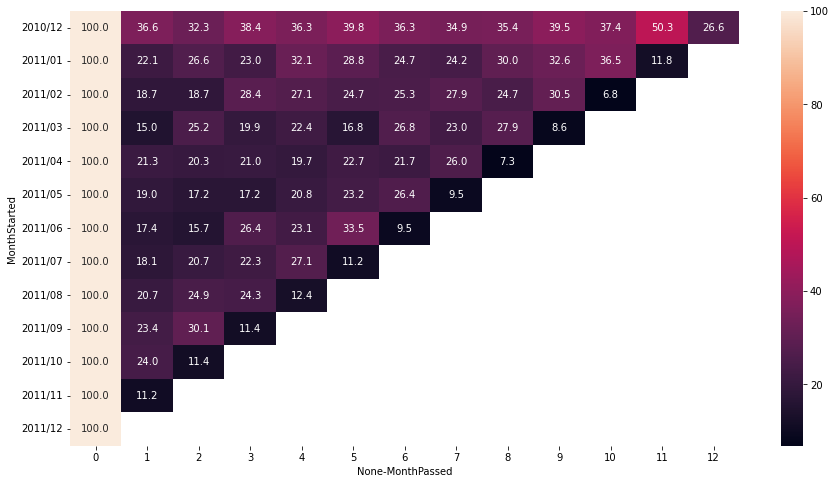

In [12]:
xticks = np.arange(0, 13)
yticks = ['2010/12', '2011/01', '2011/02', '2011/03', '2011/04', '2011/05', '2011/06', '2011/07', '2011/08', '2011/09', '2011/10', '2011/11', '2011/12']

plt.figure(figsize = (15, 8))
sns.heatmap(customer_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f')
